In [ ]:
!pip install transformers datasets tensorflow -q tldextract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5

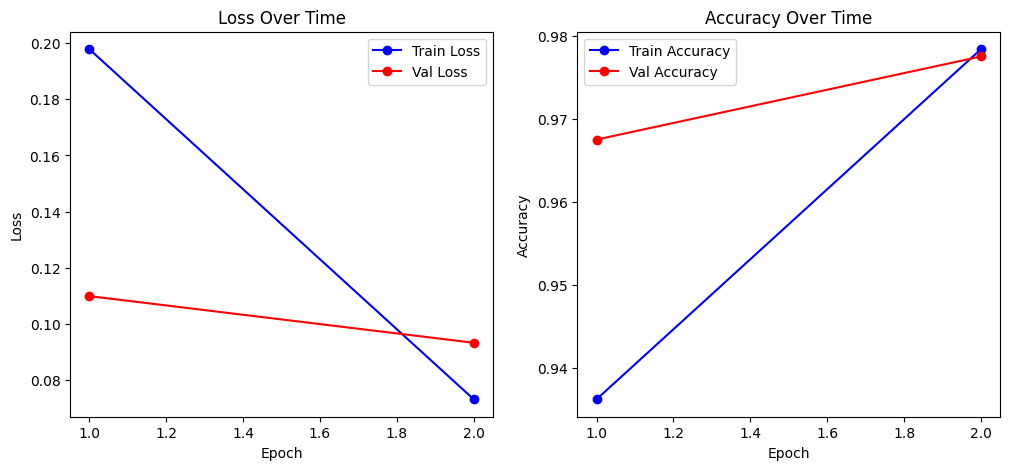

500/500 [==============================] - 68s 136ms/step - loss: 0.0732 - accuracy: 0.9784 - val_loss: 0.0933 - val_accuracy: 0.9775
Model saved in Google Drive.
🔍 URL: http://paypal.login.verify-account.com
⚠ Prediction: phishing
🔍 URL: https://www.google.com
⚠ Prediction: benign
🔍 URL: http://free-money-bonus.xyz
⚠ Prediction: benign


In [ ]:

!pip install transformers datasets tensorflow -q tldextract

import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import DataCollatorWithPadding
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from google.colab import drive

drive.mount('/content/drive')

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/malicious_phish.csv"
df = pd.read_csv(dataset_url)[:10000]

label_map = {"benign": 0, "defacement": 1, "phishing": 2, "malware": 3}
df['label'] = df['type'].map(label_map)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['url'].values, df['label'].values, test_size=0.2, random_state=42
)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=64)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    tf.convert_to_tensor(train_labels)
)).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    tf.convert_to_tensor(val_labels)
)).batch(16)

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

class TrainingVisualizer(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch + 1)
        self.train_loss.append(logs["loss"])
        self.val_loss.append(logs["val_loss"])
        self.train_acc.append(logs["accuracy"])
        self.val_acc.append(logs["val_accuracy"])

        clear_output(wait=True)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.epochs, self.train_loss, "bo-", label="Train Loss")
        plt.plot(self.epochs, self.val_loss, "ro-", label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss Over Time")

        plt.subplot(1, 2, 2)
        plt.plot(self.epochs, self.train_acc, "bo-", label="Train Accuracy")
        plt.plot(self.epochs, self.val_acc, "ro-", label="Val Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Accuracy Over Time")

        plt.show()

visualizer = TrainingVisualizer()
model.fit(train_dataset, validation_data=val_dataset, epochs=2, callbacks=[visualizer])

model_path = "/content/drive/MyDrive/AI_MaliciousLink/Model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print("Model saved in Google Drive.")

def predict_url(url):
    label_names = ["benign", "defacement", "phishing", "malware"]

    inputs = tokenizer(url, return_tensors="tf", truncation=True, padding=True, max_length=64)

    logits = model(inputs['input_ids']).logits
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]

    print(f"URL: {url}")
    print(f"Prediction: {label_names[predicted_class]}")

predict_url("http://paypal.login.verify-account.com")
predict_url("https://www.google.com")
predict_url("http://free-money-bonus.xyz")



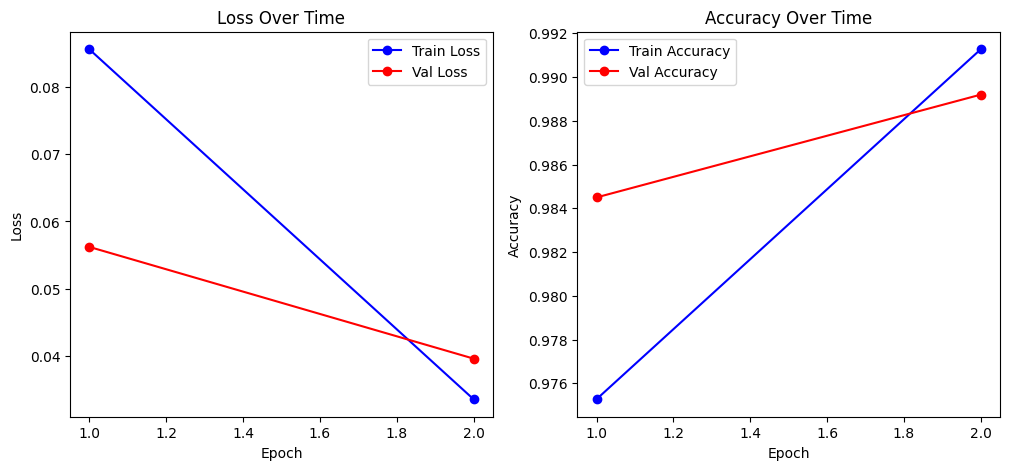

2500/2500 [==============================] - 313s 125ms/step - loss: 0.0336 - accuracy: 0.9913 - val_loss: 0.0396 - val_accuracy: 0.9892
Epoch 3/5
 418/2500 [====>.........................] - ETA: 3:55 - loss: 0.0275 - accuracy: 0.9939

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import DataCollatorWithPadding
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from google.colab import drive

drive.mount('/content/drive')

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/malicious_phish.csv"
df = pd.read_csv(dataset_url)[:50000]

label_map = {"benign": 0, "defacement": 1, "phishing": 2, "malware": 3}
df['label'] = df['type'].map(label_map)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['url'].values, df['label'].values, test_size=0.2, random_state=42
)

tokenizer = DistilBertTokenizer.from_pretrained('/content/drive/MyDrive/AI_MaliciousLink/Model')

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=64)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    tf.convert_to_tensor(train_labels)
)).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    tf.convert_to_tensor(val_labels)
)).batch(16)

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

class TrainingVisualizer(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch + 1)
        self.train_loss.append(logs["loss"])
        self.val_loss.append(logs["val_loss"])
        self.train_acc.append(logs["accuracy"])
        self.val_acc.append(logs["val_accuracy"])

        clear_output(wait=True)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.epochs, self.train_loss, "bo-", label="Train Loss")
        plt.plot(self.epochs, self.val_loss, "ro-", label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss Over Time")

        plt.subplot(1, 2, 2)
        plt.plot(self.epochs, self.train_acc, "bo-", label="Train Accuracy")
        plt.plot(self.epochs, self.val_acc, "ro-", label="Val Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Accuracy Over Time")

        plt.show()

visualizer = TrainingVisualizer()
model.fit(train_dataset, validation_data=val_dataset, epochs=5, callbacks=[visualizer])

model_path = "/content/drive/MyDrive/AI_MaliciousLink/Model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print("Model saved in Google Drive.")

def predict_url(url):
    label_names = ["benign", "defacement", "phishing", "malware"]

    inputs = tokenizer(url, return_tensors="tf", truncation=True, padding=True, max_length=64)

    logits = model(inputs['input_ids']).logits
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]

    print(f"URL: {url}")
    print(f"Prediction: {label_names[predicted_class]}")

predict_url("http://paypal.login.verify-account.com")
predict_url("https://www.google.com")
predict_url("http://free-money-bonus.xyz")

In [ ]:
!pip install tldextract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 4.0 MB/s eta 0:00:00


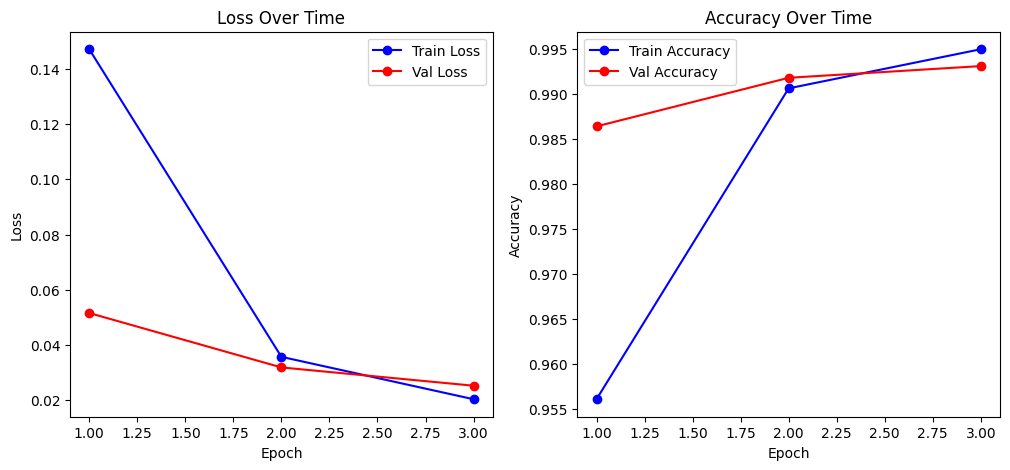

1250/1250 [==============================] - 269s 215ms/step - loss: 0.0204 - accuracy: 0.9950 - val_loss: 0.0253 - val_accuracy: 0.9931
Model saved in Google Drive.
URL: http://paypal.login.verify-account.com
Prediction: phishing
URL: https://www.google.com
Prediction: defacement
URL: http://free-money-bonus.xyz
Prediction: defacement


In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from google.colab import drive

drive.mount('/content/drive')

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/malicious_phish.csv"
df = pd.read_csv(dataset_url)[:50000]

label_map = {"benign": 0, "defacement": 1, "phishing": 2, "malware": 3}
df['label'] = df['type'].map(label_map)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['url'].values, df['label'].values, test_size=0.2, random_state=42
)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=64)

train_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    tf.convert_to_tensor(train_labels)
)).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": val_encodings["input_ids"], "attention_mask": val_encodings["attention_mask"]},
    tf.convert_to_tensor(val_labels)
)).batch(32)

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5, decay_steps=1000, decay_rate=0.96, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

class TrainingVisualizer(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs, self.train_loss, self.val_loss, self.train_acc, self.val_acc = [], [], [], [], []

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch + 1)
        self.train_loss.append(logs["loss"])
        self.val_loss.append(logs["val_loss"])
        self.train_acc.append(logs["accuracy"])
        self.val_acc.append(logs["val_accuracy"])
        clear_output(wait=True)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.epochs, self.train_loss, "bo-", label="Train Loss")
        plt.plot(self.epochs, self.val_loss, "ro-", label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss Over Time")

        plt.subplot(1, 2, 2)
        plt.plot(self.epochs, self.train_acc, "bo-", label="Train Accuracy")
        plt.plot(self.epochs, self.val_acc, "ro-", label="Val Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Accuracy Over Time")

        plt.show()

visualizer = TrainingVisualizer()

model.fit(train_dataset, validation_data=val_dataset, epochs=3, callbacks=[visualizer, early_stopping])

model_path = "/content/drive/MyDrive/AI_MaliciousLink/Model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print("Model saved in Google Drive.")

def predict_url(url):
    label_names = ["benign", "defacement", "phishing", "malware"]
    inputs = tokenizer(url, return_tensors="tf", truncation=True, padding=True, max_length=64)
    logits = model(inputs['input_ids'], attention_mask=inputs['attention_mask']).logits
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]
    print(f"URL: {url}")
    print(f"Prediction: {label_names[predicted_class]}")

predict_url("http://paypal.login.verify-account.com")
predict_url("https://www.google.com")
predict_url("http://free-money-bonus.xyz")



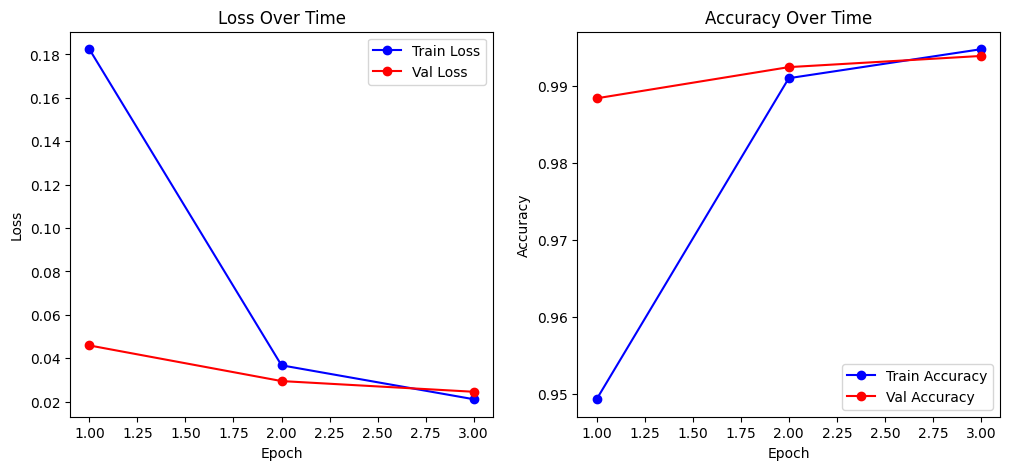

1250/1250 [==============================] - 523s 419ms/step - loss: 0.0211 - accuracy: 0.9947 - val_loss: 0.0246 - val_accuracy: 0.9938
Model saved in Google Drive.
URL: http://paypal.login.verify-account.com
Prediction: phishing
URL: https://www.google.com
Prediction: defacement
URL: http://free-money-bonus.xyz
Prediction: defacement


In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from google.colab import drive

drive.mount('/content/drive')

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/malicious_phish.csv"
df = pd.read_csv(dataset_url)[:100000]

label_map = {"benign": 0, "defacement": 1, "phishing": 2, "malware": 3}
df['label'] = df['type'].map(label_map)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['url'].values, df['label'].values, test_size=0.2, random_state=42
)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', num_labels=4, dropout_rate=0.3)

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=64)

train_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    tf.convert_to_tensor(train_labels)
)).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": val_encodings["input_ids"], "attention_mask": val_encodings["attention_mask"]},
    tf.convert_to_tensor(val_labels)
)).batch(64)

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-6, decay_steps=5000, decay_rate=0.90, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, weight_decay=0.01)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

class TrainingVisualizer(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs, self.train_loss, self.val_loss, self.train_acc, self.val_acc = [], [], [], [], []

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch + 1)
        self.train_loss.append(logs["loss"])
        self.val_loss.append(logs["val_loss"])
        self.train_acc.append(logs["accuracy"])
        self.val_acc.append(logs["val_accuracy"])
        clear_output(wait=True)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.epochs, self.train_loss, "bo-", label="Train Loss")
        plt.plot(self.epochs, self.val_loss, "ro-", label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss Over Time")

        plt.subplot(1, 2, 2)
        plt.plot(self.epochs, self.train_acc, "bo-", label="Train Accuracy")
        plt.plot(self.epochs, self.val_acc, "ro-", label="Val Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Accuracy Over Time")

        plt.show()

visualizer = TrainingVisualizer()

model.fit(train_dataset, validation_data=val_dataset, epochs=3, callbacks=[visualizer, early_stopping])

model_path = "/content/drive/MyDrive/AI_MaliciousLink/Model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print("Model saved in Google Drive.")

def predict_url(url):
    label_names = ["benign", "defacement", "phishing", "malware"]
    inputs = tokenizer(url, return_tensors="tf", truncation=True, padding=True, max_length=64)
    logits = model(inputs['input_ids'], attention_mask=inputs['attention_mask']).logits
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]
    print(f"URL: {url}")
    print(f"Prediction: {label_names[predicted_class]}")

predict_url("http://paypal.login.verify-account.com")
predict_url("https://www.google.com")
predict_url("http://free-money-bonus.xyz")

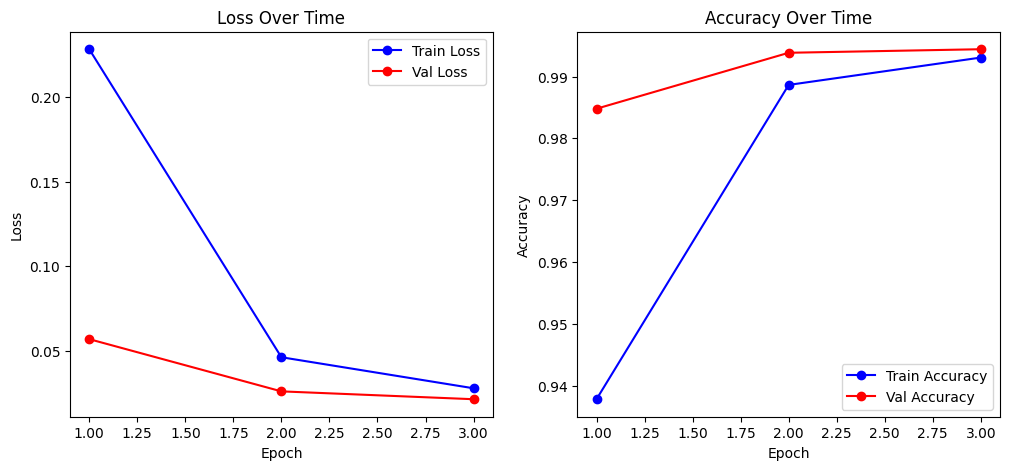

1250/1250 [==============================] - 1088s 871ms/step - loss: 0.0278 - accuracy: 0.9931 - val_loss: 0.0213 - val_accuracy: 0.9944
Model saved in Google Drive.
URL: http://paypal.login.verify-account.com
Prediction: phishing
URL: https://www.google.com
Prediction: defacement
URL: http://free-money-bonus.xyz
Prediction: defacement


In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from google.colab import drive

drive.mount('/content/drive')

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/malicious_phish.csv"
df = pd.read_csv(dataset_url)[:200000]

label_map = {"benign": 0, "defacement": 1, "phishing": 2, "malware": 3}
df['label'] = df['type'].map(label_map)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['url'].values, df['label'].values, test_size=0.2, random_state=42
)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', num_labels=4, dropout_rate=0.3)

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=64)

train_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    tf.convert_to_tensor(train_labels)
)).batch(128)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": val_encodings["input_ids"], "attention_mask": val_encodings["attention_mask"]},
    tf.convert_to_tensor(val_labels)
)).batch(128)

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-6, decay_steps=7000, decay_rate=0.90, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, weight_decay=0.01)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

class TrainingVisualizer(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs, self.train_loss, self.val_loss, self.train_acc, self.val_acc = [], [], [], [], []

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch + 1)
        self.train_loss.append(logs["loss"])
        self.val_loss.append(logs["val_loss"])
        self.train_acc.append(logs["accuracy"])
        self.val_acc.append(logs["val_accuracy"])
        clear_output(wait=True)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.epochs, self.train_loss, "bo-", label="Train Loss")
        plt.plot(self.epochs, self.val_loss, "ro-", label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss Over Time")

        plt.subplot(1, 2, 2)
        plt.plot(self.epochs, self.train_acc, "bo-", label="Train Accuracy")
        plt.plot(self.epochs, self.val_acc, "ro-", label="Val Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Accuracy Over Time")

        plt.show()

visualizer = TrainingVisualizer()

model.fit(train_dataset, validation_data=val_dataset, epochs=3, callbacks=[visualizer, early_stopping])

model_path = "/content/drive/MyDrive/AI_MaliciousLink/Model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print("Model saved in Google Drive.")

def predict_url(url):
    label_names = ["benign", "defacement", "phishing", "malware"]
    inputs = tokenizer(url, return_tensors="tf", truncation=True, padding=True, max_length=64)
    logits = model(inputs['input_ids'], attention_mask=inputs['attention_mask']).logits
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]
    print(f"URL: {url}")
    print(f"Prediction: {label_names[predicted_class]}")

predict_url("http://paypal.login.verify-account.com")
predict_url("https://www.google.com")
predict_url("http://free-money-bonus.xyz")

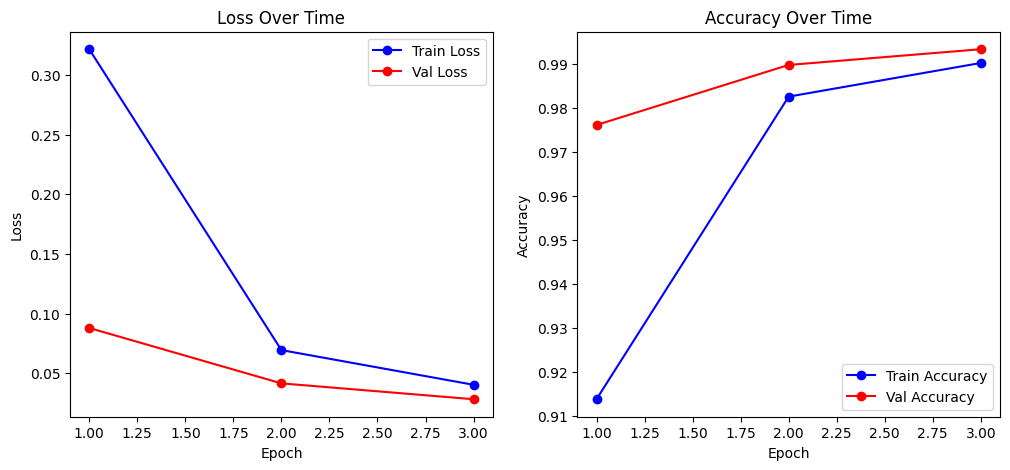

1250/1250 [==============================] - 1999s 2s/step - loss: 0.0404 - accuracy: 0.9902 - val_loss: 0.0283 - val_accuracy: 0.9933
Model saved in Google Drive.


ValueError: could not convert string to float: 'myspace.com/kyleallencater'

In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from google.colab import drive

drive.mount('/content/drive')

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/malicious_phish.csv"
df = pd.read_csv(dataset_url)[:400000]

label_map = {"benign": 0, "defacement": 1, "phishing": 2, "malware": 3}
df['label'] = df['type'].map(label_map)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['url'].values, df['label'].values, test_size=0.2, random_state=42
)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', num_labels=4, dropout_rate=0.4)

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=64)

train_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    tf.convert_to_tensor(train_labels)
)).batch(256)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": val_encodings["input_ids"], "attention_mask": val_encodings["attention_mask"]},
    tf.convert_to_tensor(val_labels)
)).batch(256)

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1.5e-6, decay_steps=12000, decay_rate=0.83, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, weight_decay=0.0175)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

class TrainingVisualizer(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs, self.train_loss, self.val_loss, self.train_acc, self.val_acc = [], [], [], [], []

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch + 1)
        self.train_loss.append(logs["loss"])
        self.val_loss.append(logs["val_loss"])
        self.train_acc.append(logs["accuracy"])
        self.val_acc.append(logs["val_accuracy"])
        clear_output(wait=True)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.epochs, self.train_loss, "bo-", label="Train Loss")
        plt.plot(self.epochs, self.val_loss, "ro-", label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss Over Time")

        plt.subplot(1, 2, 2)
        plt.plot(self.epochs, self.train_acc, "bo-", label="Train Accuracy")
        plt.plot(self.epochs, self.val_acc, "ro-", label="Val Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Accuracy Over Time")

        plt.show()

visualizer = TrainingVisualizer()

model.fit(train_dataset, validation_data=val_dataset, epochs=3, callbacks=[visualizer, early_stopping])

model_path = "/content/drive/MyDrive/AI_MaliciousLink/Model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print("Model saved in Google Drive.")

"""
def predict_url(url):
    label_names = ["benign", "defacement", "phishing", "malware"]
    inputs = tokenizer(url, return_tensors="tf", truncation=True, padding=True, max_length=64)
    logits = model(inputs['input_ids'], attention_mask=inputs['attention_mask']).logits
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]
    print(f"URL: {url}")
    print(f"Prediction: {label_names[predicted_class]}")

predict_url("http://paypal.login.verify-account.com")
predict_url("https://www.google.com")
predict_url("http://free-money-bonus.xyz")
"""


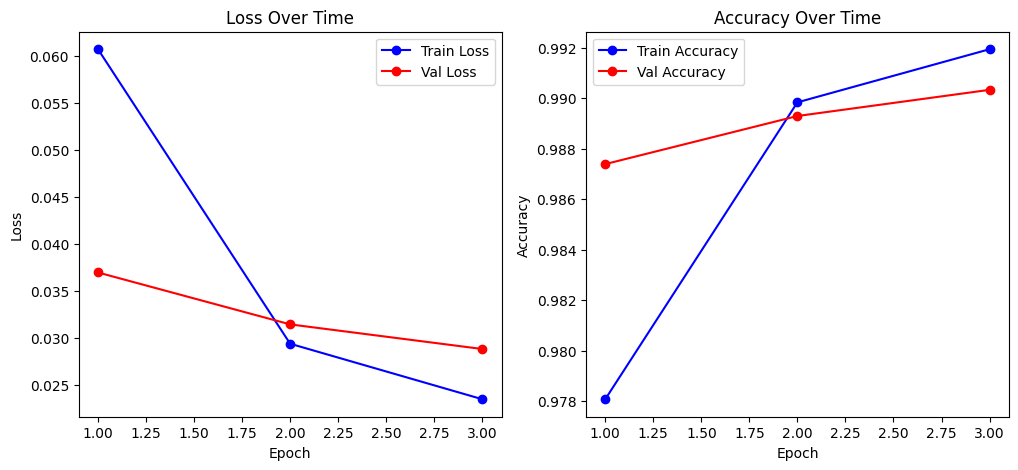

1737/1737 [==============================] - 3069s 2s/step - loss: 0.0235 - accuracy: 0.9919 - val_loss: 0.0288 - val_accuracy: 0.9903
Model saved in Google Drive.
URL: http://paypal.login.verify-account.com
Prediction: malicious
URL: https://www.google.com
Prediction: malicious
URL: http://free-money-bonus.xyz
Prediction: malicious


In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from google.colab import drive

drive.mount('/content/drive')

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/malicious_phish.csv"
df = pd.read_csv(dataset_url)

label_map = {"benign": 0, "defacement": 1, "phishing": 1, "malware": 1}
df['label'] = df['type'].map(label_map)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['url'].values, df['label'].values, test_size=0.2, random_state=42
)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=64)

train_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    tf.convert_to_tensor(train_labels)
)).batch(300)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": val_encodings["input_ids"], "attention_mask": val_encodings["attention_mask"]},
    tf.convert_to_tensor(val_labels)
)).batch(300)


model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=2e-5, decay_steps=(len(train_dataset) // 5), decay_rate=0.85, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, weight_decay=0.05)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

class TrainingVisualizer(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs, self.train_loss, self.val_loss, self.train_acc, self.val_acc = [], [], [], [], []

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch + 1)
        self.train_loss.append(logs["loss"])
        self.val_loss.append(logs["val_loss"])
        self.train_acc.append(logs["accuracy"])
        self.val_acc.append(logs["val_accuracy"])
        clear_output(wait=True)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.epochs, self.train_loss, "bo-", label="Train Loss")
        plt.plot(self.epochs, self.val_loss, "ro-", label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss Over Time")

        plt.subplot(1, 2, 2)
        plt.plot(self.epochs, self.train_acc, "bo-", label="Train Accuracy")
        plt.plot(self.epochs, self.val_acc, "ro-", label="Val Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Accuracy Over Time")

        plt.show()

visualizer = TrainingVisualizer()

model.fit(train_dataset, validation_data=val_dataset, epochs=3, callbacks=[visualizer, early_stopping])

model_path = "/content/drive/MyDrive/AI_MaliciousLink/Model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print("Model saved in Google Drive.")

def predict_url(url):
    label_names = ["benign", "malicious"]
    inputs = tokenizer(url, return_tensors="tf", truncation=True, padding=True, max_length=64)
    logits = model(inputs['input_ids'], attention_mask=inputs['attention_mask']).logits
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]
    print(f"URL: {url}")
    print(f"Prediction: {label_names[predicted_class]}")

predict_url("http://paypal.login.verify-account.com")
predict_url("https://www.google.com")
predict_url("http://free-money-bonus.xyz")

Mounted at /content/drive


All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/AI_MaliciousLink/Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Epoch 1/3
629/629 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.9964

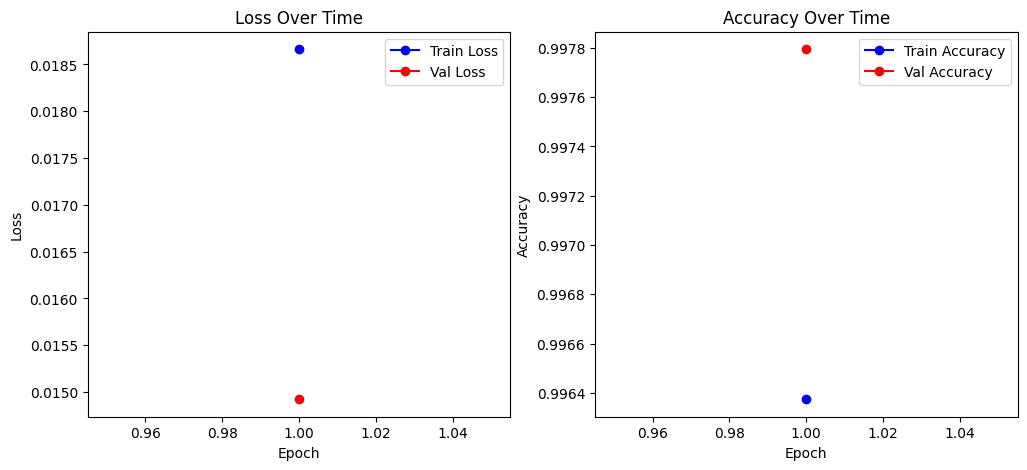

629/629 [==============================] - 1127s 2s/step - loss: 0.0187 - accuracy: 0.9964 - val_loss: 0.0149 - val_accuracy: 0.9978
Epoch 2/3
629/629 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9978

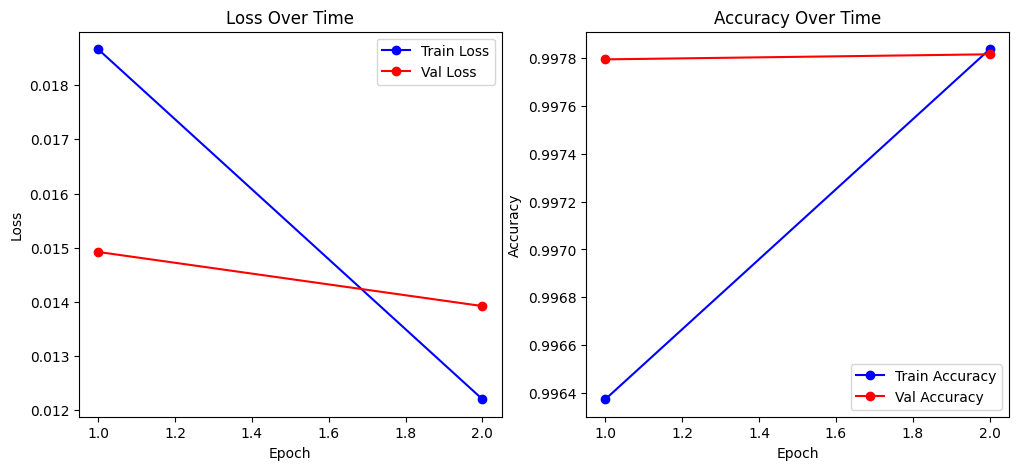

629/629 [==============================] - 1100s 2s/step - loss: 0.0122 - accuracy: 0.9978 - val_loss: 0.0139 - val_accuracy: 0.9978
Epoch 3/3
629/629 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9981

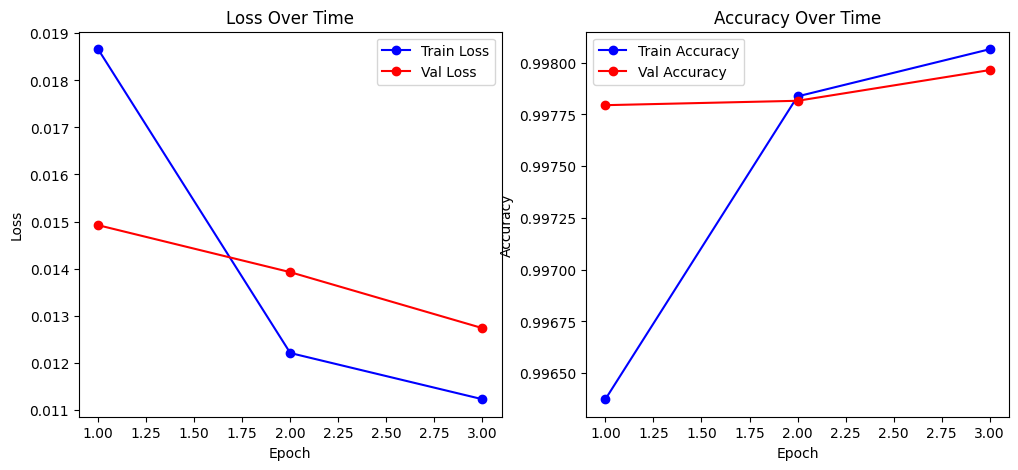

629/629 [==============================] - 1099s 2s/step - loss: 0.0112 - accuracy: 0.9981 - val_loss: 0.0127 - val_accuracy: 0.9980
Model saved in Google Drive!


In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/PhiUSIIL_Phishing_URL_Dataset.csv"
df = pd.read_csv(dataset_url)

label_map = {0: 1, 1: 0}
df['label'] = df['label'].map(label_map)



train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['URL'].values, df['label'].values, test_size=0.2, random_state=42
)

tokenizer = DistilBertTokenizer.from_pretrained('/content/drive/MyDrive/AI_MaliciousLink/Model')

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=64, return_tensors='tf')
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=64, return_tensors='tf')

train_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    tf.convert_to_tensor(train_labels)
)).batch(300)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": val_encodings["input_ids"], "attention_mask": val_encodings["attention_mask"]},
    tf.convert_to_tensor(val_labels)
)).batch(300)

model = TFDistilBertForSequenceClassification.from_pretrained(
    '/content/drive/MyDrive/AI_MaliciousLink/Model',
    num_labels=2
)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=2e-6, decay_steps=5000, decay_rate=0.90, staircase=True
)
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=0.01)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

class TrainingVisualizer(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs, self.train_loss, self.val_loss, self.train_acc, self.val_acc = [], [], [], [], []

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch + 1)
        self.train_loss.append(logs["loss"])
        self.val_loss.append(logs["val_loss"])
        self.train_acc.append(logs["accuracy"])
        self.val_acc.append(logs["val_accuracy"])

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.epochs, self.train_loss, "bo-", label="Train Loss")
        plt.plot(self.epochs, self.val_loss, "ro-", label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss Over Time")

        plt.subplot(1, 2, 2)
        plt.plot(self.epochs, self.train_acc, "bo-", label="Train Accuracy")
        plt.plot(self.epochs, self.val_acc, "ro-", label="Val Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Accuracy Over Time")

        plt.show()

visualizer = TrainingVisualizer()
model.fit(train_dataset, validation_data=val_dataset, epochs=3, callbacks=[visualizer])

model_path = "/content/drive/MyDrive/AI_MaliciousLink/Model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print("Model saved in Google Drive!")

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
import numpy as np

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/URLdataset.csv"
df = pd.read_csv(dataset_url)

text_data = df['url']
labels = df['type']

label_map = {"legitimate": 0, "defacement": 1, "phishing": 1, "malware": 1}
df['label'] = df['type'].map(label_map)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    text_data, labels, test_size=0.1, random_state=42
)


tokenizer = DistilBertTokenizer.from_pretrained('/content/drive/MyDrive/AI_MaliciousLink/Model')

model = TFDistilBertForSequenceClassification.from_pretrained(
    '/content/drive/MyDrive/AI_MaliciousLink/Model',
    num_labels=2,
    ignore_mismatched_sizes=True
)

test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=64)

test_labels = test_labels.astype(str).str.strip()

unique_labels = np.unique(test_labels)
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

y_true = np.array([label_mapping[label] for label in test_labels])

test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_true)).batch(1000)

y_pred_probs = model.predict(test_dataset).logits
y_pred = np.argmax(y_pred_probs, axis=1)

print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)
print("Unique values in y_true:", np.unique(y_true))
print("Unique values in y_pred:", np.unique(y_pred))

precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Some layers from the model checkpoint at /content/drive/MyDrive/AI_MaliciousLink/Model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/AI_MaliciousLink/Model and are newly initialized: ['dropout_119']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


46/46 [==============================] - 87s 2s/step
y_true shape: (45018,)
y_pred shape: (45018,)
Unique values in y_true: [0 1]
Unique values in y_pred: [0 1]
Precision: 0.5301
Recall: 0.5008
F1 Score: 0.1934
Confusion Matrix:
[[  168 34392]
 [   35 10423]]


In [ ]:
import pandas as pd

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/URLdataset.csv"
df = pd.read_csv(dataset_url)

print(len(df))
print(df)

450176
                                                      url        type
0                                  https://www.google.com  legitimate
1                                 https://www.youtube.com  legitimate
2                                https://www.facebook.com  legitimate
3                                   https://www.baidu.com  legitimate
4                               https://www.wikipedia.org  legitimate
...                                                   ...         ...
450171        http://ecct-it.com/docmmmnn/aptgd/index.php    phishing
450172  http://faboleena.com/js/infortis/jquery/plugin...    phishing
450173  http://faboleena.com/js/infortis/jquery/plugin...    phishing
450174                             http://atualizapj.com/    phishing
450175  http://writeassociate.com/test/Portal/inicio/I...    phishing

[450176 rows x 2 columns]


In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')

print(os.listdir("/content/drive/MyDrive/AI_MaliciousLink/Model"))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['config.json', 'vocab.txt', 'tokenizer_config.json', 'special_tokens_map.json', 'tf_model.h5']


In [ ]:
from transformers import TFDistilBertForSequenceClassification

try:
    model = TFDistilBertForSequenceClassification.from_pretrained(
        '/content/drive/MyDrive/AI_MaliciousLink/Model'
    )
    print("Model loaded successfully!")
except Exception as e:
    print("Error loading model:", e)


Some layers from the model checkpoint at /content/drive/MyDrive/AI_MaliciousLink/Model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/AI_MaliciousLink/Model and are newly initialized: ['dropout_79']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/AI_MaliciousLink/Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Epoch 1/3
1201/1201 [==============================] - ETA: 0s - loss: 0.1039 - accuracy: 0.9681

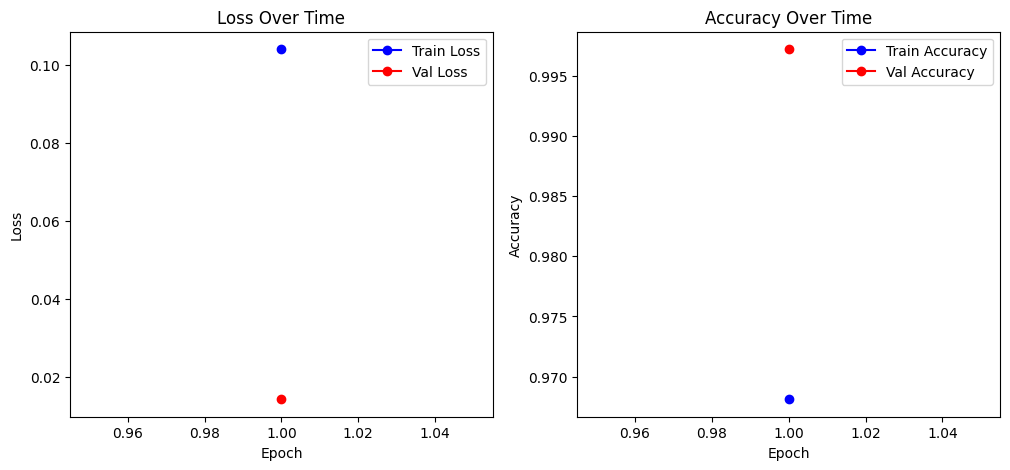

1201/1201 [==============================] - 2214s 2s/step - loss: 0.1039 - accuracy: 0.9681 - val_loss: 0.0143 - val_accuracy: 0.9972
Epoch 2/3
1201/1201 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9972

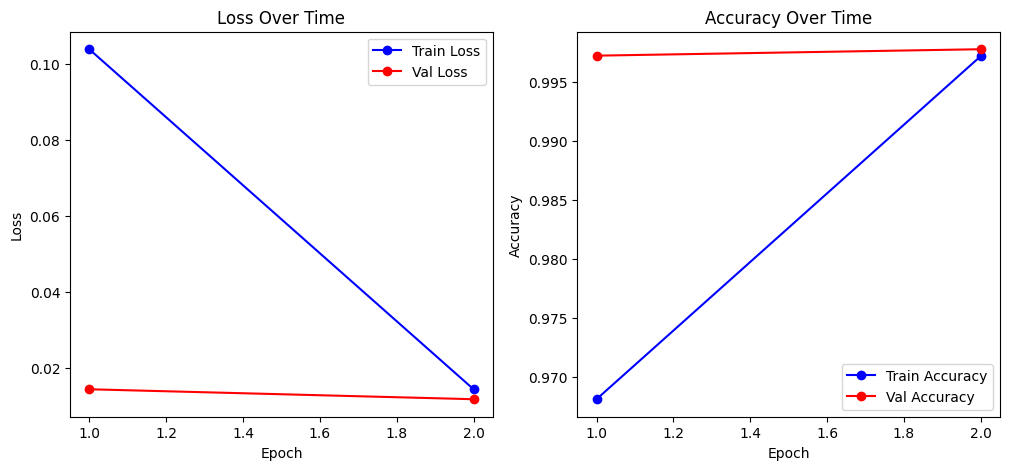

1201/1201 [==============================] - 2181s 2s/step - loss: 0.0143 - accuracy: 0.9972 - val_loss: 0.0117 - val_accuracy: 0.9977
Epoch 3/3
 731/1201 [=================>............] - ETA: 13:03 - loss: 0.0122 - accuracy: 0.9975

In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/URLdataset.csv"
df = pd.read_csv(dataset_url)

label_map = {label: idx for idx, label in enumerate(df['type'].unique())}
df['type'] = df['type'].map(label_map)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['url'].values, df['type'].values, test_size=0.2, random_state=42
)

num_labels = len(label_map)

train_labels = np.array(train_labels, dtype=np.int32)
val_labels = np.array(val_labels, dtype=np.int32)

if num_labels == 2:
    train_labels = np.array(train_labels, dtype=np.float32)
    val_labels = np.array(val_labels, dtype=np.float32)

    train_labels = np.eye(2)[train_labels.astype(int)]
    val_labels = np.eye(2)[val_labels.astype(int)]


tokenizer = DistilBertTokenizer.from_pretrained('/content/drive/MyDrive/AI_MaliciousLink/Model')

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=64, return_tensors='tf')
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=64, return_tensors='tf')

train_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    train_labels
)).batch(300)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": val_encodings["input_ids"], "attention_mask": val_encodings["attention_mask"]},
    val_labels
)).batch(300)

model = TFDistilBertForSequenceClassification.from_pretrained(
    '/content/drive/MyDrive/AI_MaliciousLink/Model',
    num_labels=num_labels
)

if num_labels == 2:
    loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
else:
    loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=2e-6, decay_steps=(len(train_dataset) // 5), decay_rate=0.90, staircase=True
)
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=0.01)

model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

class TrainingVisualizer(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs, self.train_loss, self.val_loss, self.train_acc, self.val_acc = [], [], [], [], []

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch + 1)
        self.train_loss.append(logs["loss"])
        self.val_loss.append(logs["val_loss"])
        self.train_acc.append(logs["accuracy"])
        self.val_acc.append(logs["val_accuracy"])

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.epochs, self.train_loss, "bo-", label="Train Loss")
        plt.plot(self.epochs, self.val_loss, "ro-", label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss Over Time")

        plt.subplot(1, 2, 2)
        plt.plot(self.epochs, self.train_acc, "bo-", label="Train Accuracy")
        plt.plot(self.epochs, self.val_acc, "ro-", label="Val Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Accuracy Over Time")

        plt.show()

visualizer = TrainingVisualizer()
model.fit(train_dataset, validation_data=val_dataset, epochs=3, callbacks=[visualizer])

model_path = "/content/drive/MyDrive/AI_MaliciousLink/Model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print("Model saved in Google Drive!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/AI_MaliciousLink/Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Epoch 1/3
1707/1707 [==============================] - ETA: 0s - loss: 0.0915 - accuracy: 0.9671

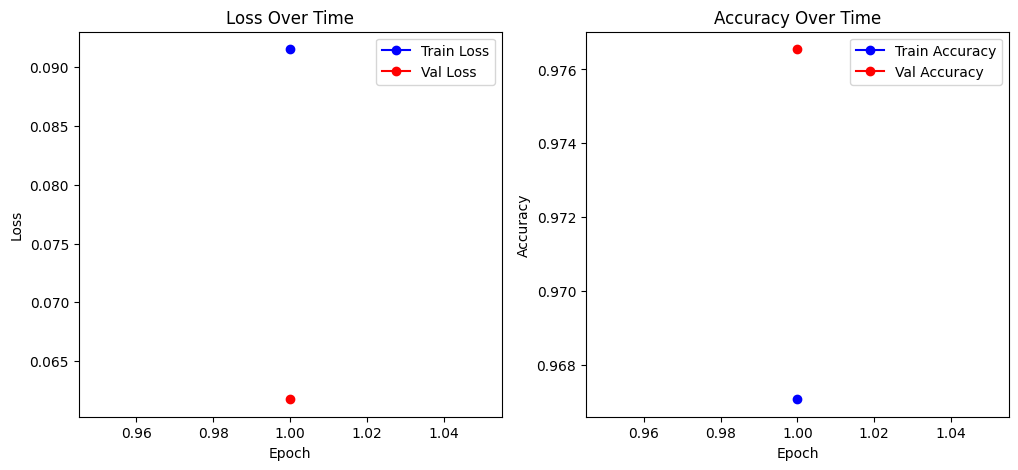

1707/1707 [==============================] - 3122s 2s/step - loss: 0.0915 - accuracy: 0.9671 - val_loss: 0.0618 - val_accuracy: 0.9765
Epoch 2/3
1707/1707 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9762

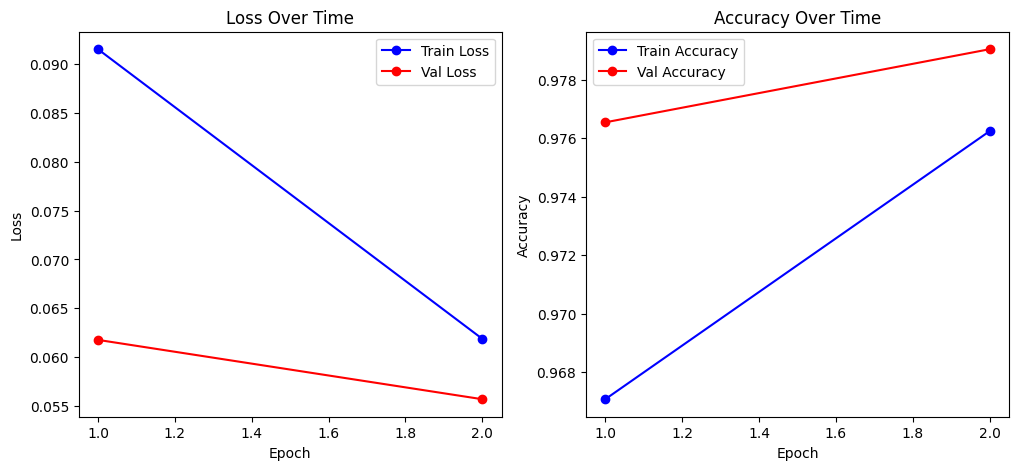

1707/1707 [==============================] - 3093s 2s/step - loss: 0.0619 - accuracy: 0.9762 - val_loss: 0.0557 - val_accuracy: 0.9790
Epoch 3/3
1707/1707 [==============================] - ETA: 0s - loss: 0.0558 - accuracy: 0.9787

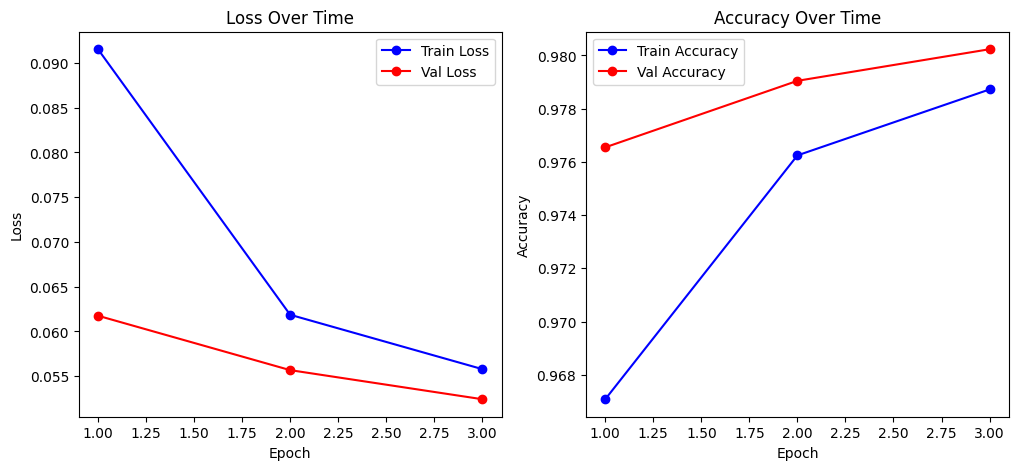

1707/1707 [==============================] - 3095s 2s/step - loss: 0.0558 - accuracy: 0.9787 - val_loss: 0.0524 - val_accuracy: 0.9802
Model saved in Google Drive!


In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/phishing_url_train.csv"
df = pd.read_csv(dataset_url)[:640000]

label_map = {label: idx for idx, label in enumerate(df['is_malicious'].unique())}
df['is_malicious'] = df['is_malicious'].map(label_map)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['url'].values, df['is_malicious'].values, test_size=0.2, random_state=42
)

tokenizer = DistilBertTokenizer.from_pretrained('/content/drive/MyDrive/AI_MaliciousLink/Model')

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=64, return_tensors='tf')
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=64, return_tensors='tf')

train_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    tf.convert_to_tensor(train_labels)
)).batch(300)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": val_encodings["input_ids"], "attention_mask": val_encodings["attention_mask"]},
    tf.convert_to_tensor(val_labels)
)).batch(300)

model = TFDistilBertForSequenceClassification.from_pretrained(
    '/content/drive/MyDrive/AI_MaliciousLink/Model',
    num_labels=2
)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=2e-6, decay_steps=20000, decay_rate=0.80, staircase=True
)
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=0.1)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

class TrainingVisualizer(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs, self.train_loss, self.val_loss, self.train_acc, self.val_acc = [], [], [], [], []

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch + 1)
        self.train_loss.append(logs["loss"])
        self.val_loss.append(logs["val_loss"])
        self.train_acc.append(logs["accuracy"])
        self.val_acc.append(logs["val_accuracy"])

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.epochs, self.train_loss, "bo-", label="Train Loss")
        plt.plot(self.epochs, self.val_loss, "ro-", label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss Over Time")

        plt.subplot(1, 2, 2)
        plt.plot(self.epochs, self.train_acc, "bo-", label="Train Accuracy")
        plt.plot(self.epochs, self.val_acc, "ro-", label="Val Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Accuracy Over Time")

        plt.show()

visualizer = TrainingVisualizer()
model.fit(train_dataset, validation_data=val_dataset, epochs=3, callbacks=[visualizer])

model_path = "/content/drive/MyDrive/AI_MaliciousLink/Model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print("Model saved in Google Drive!")

Mounted at /content/drive


All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/AI_MaliciousLink/Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Epoch 1/3
1847/1847 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 0.9571

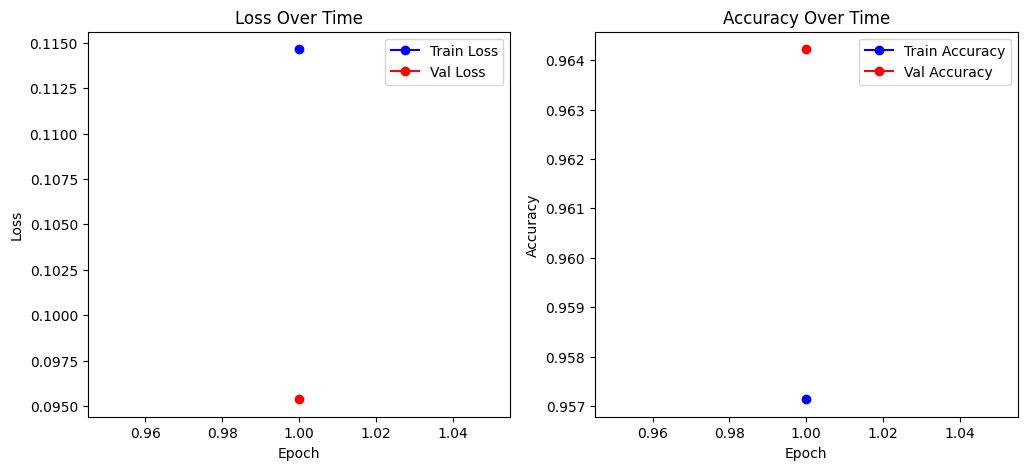

1847/1847 [==============================] - 3749s 2s/step - loss: 0.1146 - accuracy: 0.9571 - val_loss: 0.0954 - val_accuracy: 0.9642
Epoch 2/3
1847/1847 [==============================] - ETA: 0s - loss: 0.0951 - accuracy: 0.9643

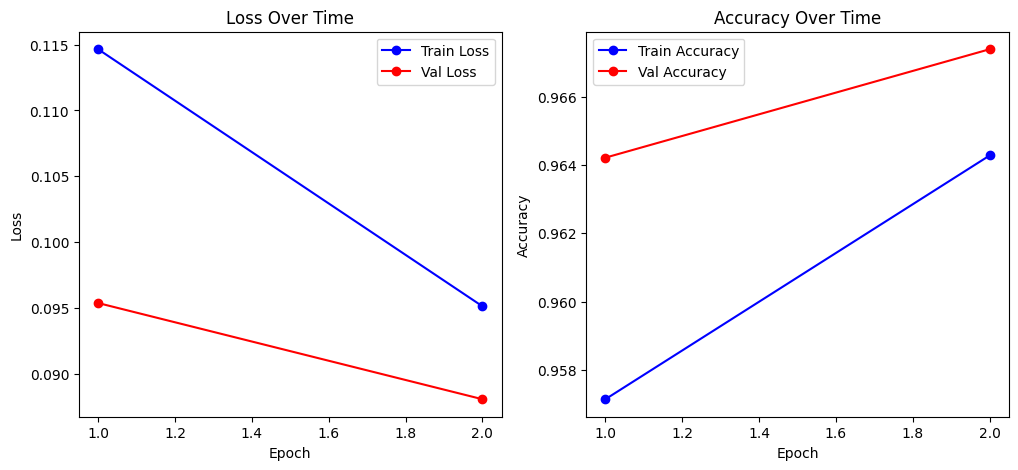

1847/1847 [==============================] - 3726s 2s/step - loss: 0.0951 - accuracy: 0.9643 - val_loss: 0.0881 - val_accuracy: 0.9674
Epoch 3/3
1847/1847 [==============================] - ETA: 0s - loss: 0.0864 - accuracy: 0.9678

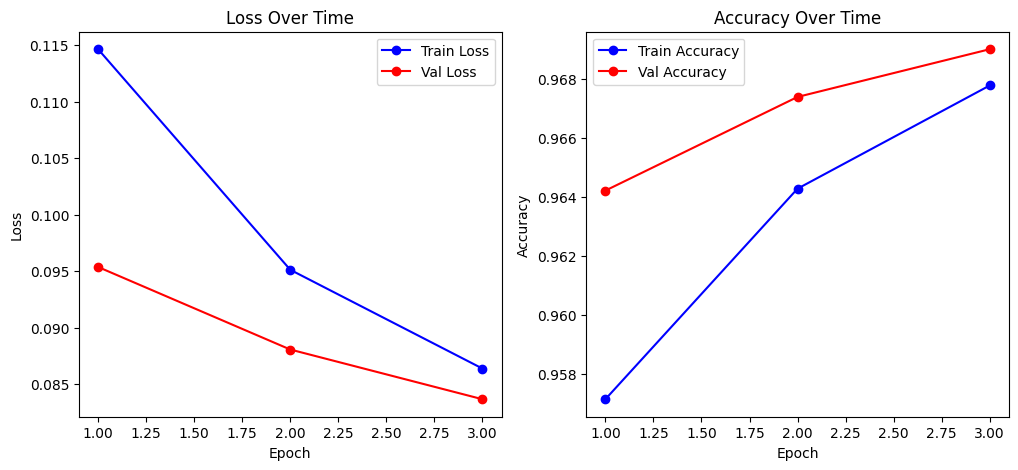

1847/1847 [==============================] - 3751s 2s/step - loss: 0.0864 - accuracy: 0.9678 - val_loss: 0.0837 - val_accuracy: 0.9690
Model saved in Google Drive!


In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/phishing_url_train.csv"
df = pd.read_csv(dataset_url)[:750000]

label_map = {label: idx for idx, label in enumerate(df['is_malicious'].unique())}
df['is_malicious'] = df['is_malicious'].map(label_map)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['url'].values, df['is_malicious'].values, test_size=0.2, random_state=42
)

tokenizer = DistilBertTokenizer.from_pretrained('/content/drive/MyDrive/AI_MaliciousLink/Model')

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=64, return_tensors='tf')
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=64, return_tensors='tf')

train_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    tf.convert_to_tensor(train_labels)
)).batch(325)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": val_encodings["input_ids"], "attention_mask": val_encodings["attention_mask"]},
    tf.convert_to_tensor(val_labels)
)).batch(325)

model = TFDistilBertForSequenceClassification.from_pretrained(
    '/content/drive/MyDrive/AI_MaliciousLink/Model',
    num_labels=2
)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=2e-6, decay_steps=40000, decay_rate=0.80, staircase=True
)
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=0.1)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=1,
    restore_best_weights=True
)

class TrainingVisualizer(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs, self.train_loss, self.val_loss, self.train_acc, self.val_acc = [], [], [], [], []

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch + 1)
        self.train_loss.append(logs["loss"])
        self.val_loss.append(logs["val_loss"])
        self.train_acc.append(logs["accuracy"])
        self.val_acc.append(logs["val_accuracy"])

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.epochs, self.train_loss, "bo-", label="Train Loss")
        plt.plot(self.epochs, self.val_loss, "ro-", label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss Over Time")

        plt.subplot(1, 2, 2)
        plt.plot(self.epochs, self.train_acc, "bo-", label="Train Accuracy")
        plt.plot(self.epochs, self.val_acc, "ro-", label="Val Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Accuracy Over Time")

        plt.show()

visualizer = TrainingVisualizer()
model.fit(train_dataset, validation_data=val_dataset, epochs=3, callbacks=[visualizer, early_stopping])

model_path = "/content/drive/MyDrive/AI_MaliciousLink/Model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print("Model saved in Google Drive!")

In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/phishing_url_train.csv"
df = pd.read_csv(dataset_url)[:1_000_000]

label_map = {label: idx for idx, label in enumerate(df['is_malicious'].unique())}
df['is_malicious'] = df['is_malicious'].map(label_map)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['url'].values, df['is_malicious'].values, test_size=0.2, random_state=42
)

tokenizer = DistilBertTokenizer.from_pretrained('/content/drive/MyDrive/AI_MaliciousLink/Model')

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=64, return_tensors='tf')
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=64, return_tensors='tf')

train_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    tf.convert_to_tensor(train_labels)
)).batch(400)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": val_encodings["input_ids"], "attention_mask": val_encodings["attention_mask"]},
    tf.convert_to_tensor(val_labels)
)).batch(400)

model = TFDistilBertForSequenceClassification.from_pretrained(
    '/content/drive/MyDrive/AI_MaliciousLink/Model',
    num_labels=2
)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1.5e-6, decay_steps=50000, decay_rate=0.80, staircase=True
)
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=0.1)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=1,
    restore_best_weights=True
)

class TrainingVisualizer(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs, self.train_loss, self.val_loss, self.train_acc, self.val_acc = [], [], [], [], []

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch + 1)
        self.train_loss.append(logs["loss"])
        self.val_loss.append(logs["val_loss"])
        self.train_acc.append(logs["accuracy"])
        self.val_acc.append(logs["val_accuracy"])

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.epochs, self.train_loss, "bo-", label="Train Loss")
        plt.plot(self.epochs, self.val_loss, "ro-", label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss Over Time")

        plt.subplot(1, 2, 2)
        plt.plot(self.epochs, self.train_acc, "bo-", label="Train Accuracy")
        plt.plot(self.epochs, self.val_acc, "ro-", label="Val Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Accuracy Over Time")

        plt.show()

visualizer = TrainingVisualizer()
model.fit(train_dataset, validation_data=val_dataset, epochs=3, callbacks=[visualizer, early_stopping])

model_path = "/content/drive/MyDrive/AI_MaliciousLink/Model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
model.config.save_pretrained(model_path)

print("Model saved in Google Drive!")

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/AI_MaliciousLink/Dataset/phishing_url_train.csv")[:750000]

print(df.info())

print(df.head())

print(df['is_malicious'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   url           750000 non-null  object
 1   is_malicious  750000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 11.4+ MB
None
                         url  is_malicious
0     https://www.google.com             0
1    https://www.youtube.com             0
2   https://www.facebook.com             0
3      https://www.baidu.com             0
4  https://www.wikipedia.org             0
is_malicious
0    381289
1    368711
Name: count, dtype: int64


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/URLdataset.csv"
df = pd.read_csv(dataset_url)

text_data = df['url']
labels = df['type']

label_map = {"legitimate": 0, "phishing": 1}
df['label'] = df['type'].map(label_map)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    text_data, labels, test_size=0.1, random_state=42
)


tokenizer = DistilBertTokenizer.from_pretrained('/content/drive/MyDrive/AI_MaliciousLink/Model')

model = TFDistilBertForSequenceClassification.from_pretrained(
    '/content/drive/MyDrive/AI_MaliciousLink/Model',
    num_labels=2,
    ignore_mismatched_sizes=True
)

test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=64)

test_labels = test_labels.astype(str).str.strip()

unique_labels = np.unique(test_labels)
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

y_true = np.array([label_mapping[label] for label in test_labels])

test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_true)).batch(1000)

y_pred_probs = model.predict(test_dataset).logits
y_pred = np.argmax(y_pred_probs, axis=1)

print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)
print("Unique values in y_true:", np.unique(y_true))
print("Unique values in y_pred:", np.unique(y_pred))

precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Mounted at /content/drive


All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/AI_MaliciousLink/Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


46/46 [==============================] - 94s 2s/step
y_true shape: (45018,)
y_pred shape: (45018,)
Unique values in y_true: [0 1]
Unique values in y_pred: [0 1]
Precision: 0.9978
Recall: 0.9962
F1 Score: 0.9970
Confusion Matrix:
[[34537    23]
 [   73 10385]]


In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

xlsx_file = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/data_bal.xlsx"
df = pd.read_excel(xlsx_file)

csv_file = "data_bal.csv"
df.to_csv(csv_file, index=False)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

data_set ="/content/drive/MyDrive/AI_MaliciousLink/Dataset/data_bal.csv"
df = pd.read_csv(data_set)

print(df)


       Labels                                               URLs
0           1         http://dbs.vote-friend.com/sg?ref=anything
1           0  https://www.reynoldstransfer.com/versa-lift-fo...
2           1       https://www.halisupportservice.com/Login.php
3           0  https://www.signets.com.br/wp-includes/wlwmani...
4           1  https://docs.google.com/document/d/e/2PACX-1vT...
...       ...                                                ...
19995       1      https://messagerievocale56.wixsite.com/orange
19996       1  https://06e6f4d3bb4140516.temporary.link/pt/DS...
19997       1  http://lbcpszonaseguravialbcp.cub-medisc.com/1...
19998       0  https://dljproduce.com/produce-commodity-calen...
19999       0             https://www.vineinternational.org/team

[20000 rows x 2 columns]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/data_bal.csv"
df = pd.read_csv(dataset_url)

text_data = df['URLs']
labels = df['Labels']

train_texts, test_texts, train_labels, test_labels = train_test_split(
    text_data, labels, test_size=0.1, random_state=42
)


tokenizer = DistilBertTokenizer.from_pretrained('/content/drive/MyDrive/AI_MaliciousLink/Model')

model = TFDistilBertForSequenceClassification.from_pretrained(
    '/content/drive/MyDrive/AI_MaliciousLink/Model',
    num_labels=2,
    ignore_mismatched_sizes=True
)

test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=64)

test_labels = test_labels.astype(str).str.strip()

unique_labels = np.unique(test_labels)
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

y_true = np.array([label_mapping[label] for label in test_labels])

test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_true)).batch(100)

y_pred_probs = model.predict(test_dataset).logits
y_pred = np.argmax(y_pred_probs, axis=1)

print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)
print("Unique values in y_true:", np.unique(y_true))
print("Unique values in y_pred:", np.unique(y_pred))

precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some layers from the model checkpoint at /content/drive/MyDrive/AI_MaliciousLink/Model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/AI_MaliciousLink/Model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


20/20 [==============================] - 6s 182ms/step
y_true shape: (2000,)
y_pred shape: (2000,)
Unique values in y_true: [0 1]
Unique values in y_pred: [0 1]
Precision: 0.9425
Recall: 0.9425
F1 Score: 0.9425
Confusion Matrix:
[[943  55]
 [ 60 942]]


In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/data_bal.csv"
df = pd.read_csv(dataset_url)

text_data = df['URLs'].astype(str)
labels = df['Labels'].astype(int)

tokenizer = DistilBertTokenizer.from_pretrained('/content/drive/MyDrive/AI_MaliciousLink/Model')
model = TFDistilBertForSequenceClassification.from_pretrained(
    '/content/drive/MyDrive/AI_MaliciousLink/Model',
    num_labels=2,
    ignore_mismatched_sizes=True
)

test_encodings = tokenizer(list(text_data), truncation=True, padding=True, max_length=64)

y_true = np.array(labels)

test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_true)).batch(1000)

y_pred_probs = model.predict(test_dataset).logits
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Mounted at /content/drive


All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/AI_MaliciousLink/Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


20/20 [==============================] - 51s 2s/step
Precision: 0.9391
Recall: 0.9390
F1 Score: 0.9390
Confusion Matrix:
[[9415  585]
 [ 634 9366]]


In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

data_set ="/content/drive/MyDrive/AI_MaliciousLink/Dataset/phishing_url_val.csv"
df = pd.read_csv(data_set)

print(df)

Mounted at /content/drive
                                                      url  is_malicious
0       http://huskasitu.com/New directory/k9G5zscreen...           1.0
1             http://pcweek.ru/themes/detail.php?id=48440           0.0
2       https://ariumliving.com/houston/crossroads/ari...           0.0
3       https://www.tajhotels.com/luxury/city-hotels/t...           0.0
4              http://www.konami.jp/mgs_pw/en/index2.html           0.0
...                                                   ...           ...
384074                 http://nodepression.com/user/75856           0.0
384075  http://business-eb.client22501339-form.bbt.com...           1.0
384076  http://myapple-login.com.daflonpneus.com.br/up...           1.0
384077               http://shopping4u.in/js/ceo/Arch/sb/           1.0
384078                         http://allfreecounter.com/           0.0

[384079 rows x 2 columns]


In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/phishing_url_val.csv"
df = pd.read_csv(dataset_url)

text_data = df['url'].astype(str)
labels = df['is_malicious'].astype(int)

tokenizer = DistilBertTokenizer.from_pretrained('/content/drive/MyDrive/AI_MaliciousLink/Model')
model = TFDistilBertForSequenceClassification.from_pretrained(
    '/content/drive/MyDrive/AI_MaliciousLink/Model',
    num_labels=2,
    ignore_mismatched_sizes=True
)

test_encodings = tokenizer(list(text_data), truncation=True, padding=True, max_length=64)

y_true = np.array(labels)

test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_true)).batch(1000)

y_pred_probs = model.predict(test_dataset).logits
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some layers from the model checkpoint at /content/drive/MyDrive/AI_MaliciousLink/Model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/AI_MaliciousLink/Model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


385/385 [==============================] - 830s 2s/step
Precision: 0.8548
Recall: 0.7810
F1 Score: 0.7764
Confusion Matrix:
[[103611  79957]
 [   505 200006]]


In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/data_bal.csv"
df = pd.read_csv(dataset_url)

text_data = df['URLs'].astype(str)
labels = df['Labels'].astype(int)

tokenizer = DistilBertTokenizer.from_pretrained('/content/drive/MyDrive/AI_MaliciousLink/Model')
model = TFDistilBertForSequenceClassification.from_pretrained(
    '/content/drive/MyDrive/AI_MaliciousLink/Model',
    num_labels=2,
    ignore_mismatched_sizes=True
)

test_encodings = tokenizer(list(text_data), truncation=True, padding=True, max_length=64)

y_true = np.array(labels)

test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_true)).batch(1000)

y_pred_probs = model.predict(test_dataset).logits
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some layers from the model checkpoint at /content/drive/MyDrive/AI_MaliciousLink/Model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/AI_MaliciousLink/Model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


20/20 [==============================] - 43s 2s/step
Precision: 0.9213
Recall: 0.9191
F1 Score: 0.9189
Confusion Matrix:
[[8829 1171]
 [ 448 9552]]


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/data_bal.csv"
df = pd.read_csv(dataset_url)

text_data = df['URLs'].astype(str)
labels = df['Labels'].astype(int)

tokenizer = DistilBertTokenizer.from_pretrained('/content/drive/MyDrive/AI_MaliciousLink/Model')
model = TFDistilBertForSequenceClassification.from_pretrained(
    '/content/drive/MyDrive/AI_MaliciousLink/Model',
    num_labels=2,
    ignore_mismatched_sizes=True
)

test_encodings = tokenizer(list(text_data), truncation=True, padding=True, max_length=64)

y_true = np.array(labels)

test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_true)).batch(1000)

y_pred_probs = model.predict(test_dataset).logits
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Mounted at /content/drive


All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/AI_MaliciousLink/Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


20/20 [==============================] - 44s 2s/step
Accuracy: 0.9619
Precision: 0.9620
Recall: 0.9620
F1 Score: 0.9619
Confusion Matrix:
[[9573  427]
 [ 334 9666]]


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/phishing_url_val.csv"
df = pd.read_csv(dataset_url)

text_data = df['url'].astype(str)
labels = df['is_malicious'].astype(int)

tokenizer = DistilBertTokenizer.from_pretrained('/content/drive/MyDrive/AI_MaliciousLink/Model')
model = TFDistilBertForSequenceClassification.from_pretrained(
    '/content/drive/MyDrive/AI_MaliciousLink/Model',
    num_labels=2,
    ignore_mismatched_sizes=True
)

test_encodings = tokenizer(list(text_data), truncation=True, padding=True, max_length=64)

y_true = np.array(labels)

test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_true)).batch(1000)

y_pred_probs = model.predict(test_dataset).logits
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some layers from the model checkpoint at /content/drive/MyDrive/AI_MaliciousLink/Model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/AI_MaliciousLink/Model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


385/385 [==============================] - 747s 2s/step
Accuracy: 0.9697
Precision: 0.9706
Recall: 0.9689
F1 Score: 0.9695
Confusion Matrix:
[[174867   8701]
 [  2955 197556]]


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

dataset_url = "/content/drive/MyDrive/AI_MaliciousLink/Dataset/new_data_urls.csv"
df = pd.read_csv(dataset_url)

label_map = {1: 0, 0: 1}
df['status'] = df['status'].map(label_map)


text_data = df["url"].astype(str)
labels = df["status"].astype(int)

tokenizer = DistilBertTokenizer.from_pretrained("/content/drive/MyDrive/AI_MaliciousLink/Model")
model = TFDistilBertForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/AI_MaliciousLink/Model",
    num_labels = 2,
    ignore_mismatched_sizes = True
)

test_encodings = tokenizer(list(text_data), truncation=True, padding=True, max_length=64)

y_true = np.array(labels)

test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_true)).batch(2000)

y_pred_probs = model.predict(test_dataset).logits
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy: 4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Mounted at /content/drive


All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/AI_MaliciousLink/Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


412/412 [==============================] - 1650s 4s/step
Accuracy:  0.979565
Precision: 0.9799
Recall: 0.9792
F1 Score: 0.9795
Confusion Matrix:
[[421810   5218]
 [ 11580 383402]]
